# Notebook III


In this notebook, we will load the trained models and make inference on
- Training data
- Validation data
- Test data

We will examine the following metrics in order to evaluate the performance of our models.
- Accuracy
- Precision
- Recall
- F-score
- ROC score

Despite the fact that **accuracy** is a very intuitive metric that is simple to be understood by most people (both technical and non-technical), it is essential to beware of two major caveats in this context.

First, the datasets are severely **imbalanced**. In both the training and the testing datasets, positive observations outnumber negative observations by a substantial margin (3843 vs. 1312 in training set, 390 vs. 234 in testing set). Thus, we need to employ some base-rate invariant metrics (such as F-score) to obtain a more robust evaluation.

Second, the costs associated with **false positives** and **false negatives** differ immensely. Since we are operating in the medical field, a false negative would typically lead to far greater consequences than a false positive, in that the latter would cause some minor panic and potentially prompt a re-examination, while the former would lead to a lack of crucial treatment, allowing the patient's condition to deteriorate unchecked.

Therefore, we will evaluate the models in favor of metrics that are robust to class imbalance. In addition, we will plot **ROC curves** on a handful of selected models to provide a direct view of the model performance.

### Mount to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/My Drive/Projects/Pneumonia_X_Ray/'

/content/gdrive/My Drive/Projects/Pneumonia_X_Ray


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='whitegrid')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Add path to sys
import sys
sys.path.insert(0, 'code')
sys.path.insert(0, 'code/imbalanced-dataset-sampler')

In [0]:
from models import *
from utils import *

### Set device

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is: {}'.format(device))

Device is: cuda


### Set paths

In [0]:
# Dataset paths
trainPath = 'data/chest_xray_cropped/train'
testPath = 'data/chest_xray_cropped/test'
valPath = 'data/chest_xray_cropped/val'

# Output path
outputPath = 'output'

### Read in test data

In [8]:
batchSize = 32

### 224 by 224 ###
# Training set
dataloaderTrain224, classToIdxTest = imagesToDataloader(trainPath, batch_size=batchSize, train=False)
# Val set
dataloaderVal224, classToIdxTest = imagesToDataloader(valPath, batch_size=batchSize, train=False)
# Test set
dataloaderTest224, classToIdxTest = imagesToDataloader(testPath, batch_size=batchSize, train=False)

### 299 by 299 ###
trans299 = transforms.Compose([
                    transforms.Resize(299),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
# Training set
dataloaderTrain299, classToIdxTest = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans299, train=False)
# Val set
dataloaderVal299, classToIdxTest = imagesToDataloader(valPath, batch_size=batchSize, trans=trans299, train=False)
# Test set
dataloaderTest299, classToIdxTest = imagesToDataloader(testPath, batch_size=batchSize, trans=trans299, train=False)

### 600 by 600 ###
trans600 = transforms.Compose([
                    transforms.Resize(600),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
# Training set
dataloaderTrain600, classToIdxTest = imagesToDataloader(trainPath, batch_size=batchSize, trans=trans600, train=False)
# Val set
dataloaderVal600, classToIdxTest = imagesToDataloader(valPath, batch_size=batchSize, trans=trans600, train=False)
# Test set
dataloaderTest600, classToIdxTest = imagesToDataloader(testPath, batch_size=batchSize, trans=trans600, train=False)


Mode: Training is False
Dataloader created
Mode: Training is False
Dataloader created
Mode: Training is False
Dataloader created


## Define model paths

In [0]:
modelPathDict = {'AlexNet': ['alexnet_best.pt', 'alexnet_aug_best.pt', 'alexnet_600_best.pt', 'alexnet_600_aug_best.pt'],
                 'ResNet': ['resnet_best.pt', 'resnet_aug_best.pt', 'resnet_600_best.pt', 'resnet_600_aug_best.pt'],
                 'InceptionNet': ['inceptionnet_best.pt', 'inceptionnet_aug_best.pt', 'inceptionnet_600_best.pt', 'inceptionnet_600_aug_best.pt']}

## Evaluation

In [0]:
# Create 3 dicts to store the metrics associated with each model
trainMetrics = {}
valMetrics = {}
testMetrics = {}

### AlexNet

#### Scheme 1: Standard

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['AlexNet'][0])

# Load model
model = AlexNetXray() # Use default setting
model.to(device)
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain224, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Alex_Standard'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal224, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Alex_Standard'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest224, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Alex_Standard'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [1:14:42, 27.67s/it]
0it [00:00, ?it/s]

Train accuracy 0.9934
Train precision 1.0000
Train recall 0.9912
Train f-score 0.9956
Evaluating...


3it [01:04, 21.58s/it]
0it [00:00, ?it/s]

Val accuracy 0.9740
Val precision 0.9750
Val recall 0.9750
Val f-score 0.9750
Evaluating...


20it [08:54, 26.75s/it]

Test accuracy 0.8333
Test precision 0.7918
Test recall 0.9949
Test f-score 0.8818


#### Scheme 2: Augmented Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['AlexNet'][1])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain224, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Alex_Aug'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal224, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Alex_Aug'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest224, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Alex_Aug'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [01:51,  1.46it/s]
0it [00:00, ?it/s]

Train accuracy 0.9783
Train precision 0.9987
Train recall 0.9722
Train f-score 0.9852
Evaluating...


3it [00:01,  1.52it/s]
0it [00:00, ?it/s]

Val accuracy 0.9870
Val precision 0.9756
Val recall 1.0000
Val f-score 0.9877
Evaluating...


20it [00:14,  1.37it/s]

Test accuracy 0.8574
Test precision 0.8182
Test recall 0.9923
Test f-score 0.8969


#### Scheme 3: 600 $\times$ 600 Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['AlexNet'][2])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain600, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Alex_600'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal600, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Alex_600'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest600, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Alex_600'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [03:03,  1.13s/it]
0it [00:00, ?it/s]

Train accuracy 0.9835
Train precision 0.9989
Train recall 0.9789
Train f-score 0.9888
Evaluating...


3it [00:03,  1.00s/it]
0it [00:00, ?it/s]

Val accuracy 0.9870
Val precision 1.0000
Val recall 0.9750
Val f-score 0.9873
Evaluating...


20it [00:22,  1.14s/it]

Test accuracy 0.8446
Test precision 0.8058
Test recall 0.9897
Test f-score 0.8884


#### Scheme 4: Augmented 600 $\times$ 600 Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['AlexNet'][3])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain600, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Alex_Aug_600'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal600, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Alex_Aug_600'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest600, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Alex_Aug_600'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [03:08,  1.16s/it]
0it [00:00, ?it/s]

Train accuracy 0.9783
Train precision 0.9973
Train recall 0.9735
Train f-score 0.9853
Evaluating...


3it [00:03,  1.02s/it]
0it [00:00, ?it/s]

Val accuracy 0.9870
Val precision 0.9756
Val recall 1.0000
Val f-score 0.9877
Evaluating...


20it [00:23,  1.16s/it]

Test accuracy 0.8333
Test precision 0.7955
Test recall 0.9872
Test f-score 0.8810


### ResNet-50

#### Scheme 1: Standard

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['ResNet'][0])

# Load model
model = ResNet50Xray() # Use default setting
model.to(device)
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain224, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Res_Standard'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal224, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Res_Standard'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest224, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Res_Standard'] = [acc, precision, recall, fscore]


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


0it [00:00, ?it/s]

Evaluating...


162it [02:06,  1.28it/s]
0it [00:00, ?it/s]

Train accuracy 0.9771
Train precision 0.9908
Train recall 0.9784
Train f-score 0.9846
Evaluating...


3it [00:02,  1.38it/s]
0it [00:00, ?it/s]

Val accuracy 0.9610
Val precision 0.9302
Val recall 1.0000
Val f-score 0.9639
Evaluating...


20it [00:15,  1.26it/s]

Test accuracy 0.8173
Test precision 0.7794
Test recall 0.9872
Test f-score 0.8710


#### Scheme 2: Augmented Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['ResNet'][1])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain224, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Res_Aug'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal224, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Res_Aug'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest224, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Res_Aug'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [02:05,  1.29it/s]
0it [00:00, ?it/s]

Train accuracy 0.9620
Train precision 0.9908
Train recall 0.9578
Train f-score 0.9741
Evaluating...


3it [00:02,  1.39it/s]
0it [00:00, ?it/s]

Val accuracy 0.9610
Val precision 0.9512
Val recall 0.9750
Val f-score 0.9630
Evaluating...


20it [00:16,  1.25it/s]

Test accuracy 0.8109
Test precision 0.7857
Test recall 0.9590
Test f-score 0.8637


#### Scheme 3: 600 $\times$ 600 Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['ResNet'][2])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain600, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Res_600'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal600, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Res_600'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest600, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Res_600'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [04:45,  1.76s/it]
0it [00:00, ?it/s]

Train accuracy 0.8881
Train precision 0.9585
Train recall 0.8884
Train f-score 0.9221
Evaluating...


3it [00:04,  1.53s/it]
0it [00:00, ?it/s]

Val accuracy 0.8312
Val precision 0.8293
Val recall 0.8500
Val f-score 0.8395
Evaluating...


20it [00:35,  1.76s/it]

Test accuracy 0.7740
Test precision 0.7655
Test recall 0.9205
Test f-score 0.8359


#### Scheme 4: Augmented 600 $\times$ 600 Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['ResNet'][3])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain600, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Res_Aug_600'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal600, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Res_Aug_600'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest600, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Res_Aug_600'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [04:43,  1.75s/it]
0it [00:00, ?it/s]

Train accuracy 0.9113
Train precision 0.9924
Train recall 0.8878
Train f-score 0.9372
Evaluating...


3it [00:04,  1.50s/it]
0it [00:00, ?it/s]

Val accuracy 0.8961
Val precision 0.8636
Val recall 0.9500
Val f-score 0.9048
Evaluating...


20it [00:35,  1.75s/it]

Test accuracy 0.8478
Test precision 0.8454
Test recall 0.9256
Test f-score 0.8837


### InceptionNet v3

#### Scheme 1: Standard

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['InceptionNet'][0])

# Load model
model = InceptionNetXray() # Use default setting
model.to(device)
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain299, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Inception_Standard'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal299, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Inception_Standard'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest299, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Inception_Standard'] = [acc, precision, recall, fscore]


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


0it [00:00, ?it/s]

Evaluating...


162it [02:17,  1.18it/s]
0it [00:00, ?it/s]

Train accuracy 0.9694
Train precision 0.9899
Train recall 0.9688
Train f-score 0.9792
Evaluating...


3it [00:02,  1.30it/s]
0it [00:00, ?it/s]

Val accuracy 0.9610
Val precision 0.9302
Val recall 1.0000
Val f-score 0.9639
Evaluating...


20it [00:17,  1.12it/s]

Test accuracy 0.8285
Test precision 0.7930
Test recall 0.9821
Test f-score 0.8774


#### Scheme 2: Augmented Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['InceptionNet'][1])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain299, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Inception_Aug'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal299, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Inception_Aug'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest299, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Inception_Aug'] = [acc, precision, recall, fscore]


0it [00:00, ?it/s]

Evaluating...


162it [02:17,  1.18it/s]
0it [00:00, ?it/s]

Train accuracy 0.9205
Train precision 0.9928
Train recall 0.8998
Train f-score 0.9440
Evaluating...


3it [00:02,  1.26it/s]
0it [00:00, ?it/s]

Val accuracy 0.8961
Val precision 0.9444
Val recall 0.8500
Val f-score 0.8947
Evaluating...


20it [00:17,  1.15it/s]

Test accuracy 0.8157
Test precision 0.8104
Test recall 0.9205
Test f-score 0.8619


#### Scheme 3: 600 $\times$ 600 Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['InceptionNet'][2])

# Load model
# model = InceptionNetXray() # Use default setting
model.to(device)
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain600, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Inception_600'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal600, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Inception_600'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest600, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Inception_600'] = [acc, precision, recall, fscore]

0it [00:00, ?it/s]

Evaluating...


162it [04:15,  1.58s/it]
0it [00:00, ?it/s]

Train accuracy 0.9606
Train precision 0.9828
Train recall 0.9641
Train f-score 0.9733
Evaluating...


3it [00:04,  1.38s/it]
0it [00:00, ?it/s]

Val accuracy 0.9351
Val precision 0.8889
Val recall 1.0000
Val f-score 0.9412
Evaluating...


20it [00:31,  1.59s/it]

Test accuracy 0.7788
Test precision 0.7530
Test recall 0.9615
Test f-score 0.8446


#### Scheme 4: Augmented 600 $\times$ 600 Data

In [0]:
# Path to save model
modelPath = os.path.join('models', modelPathDict['InceptionNet'][3])

# Load model
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))

# Train set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTrain600, device)
print('Train accuracy {:.4f}'.format(acc))
print('Train precision {:.4f}'.format(precision))
print('Train recall {:.4f}'.format(recall))
print('Train f-score {:.4f}'.format(fscore))
trainMetrics['Inception_Aug_600'] = [acc, precision, recall, fscore]
# Val set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderVal600, device)
print('Val accuracy {:.4f}'.format(acc))
print('Val precision {:.4f}'.format(precision))
print('Val recall {:.4f}'.format(recall))
print('Val f-score {:.4f}'.format(fscore))
valMetrics['Inception_Aug_600'] = [acc, precision, recall, fscore]
# Test set
_, _, _, acc, precision, recall, fscore = evaluate(model, dataloaderTest600, device)
print('Test accuracy {:.4f}'.format(acc))
print('Test precision {:.4f}'.format(precision))
print('Test recall {:.4f}'.format(recall))
print('Test f-score {:.4f}'.format(fscore))
testMetrics['Inception_Aug_600'] = [acc, precision, recall, fscore]

0it [00:00, ?it/s]

Evaluating...


162it [04:17,  1.59s/it]
0it [00:00, ?it/s]

Train accuracy 0.9288
Train precision 0.9839
Train recall 0.9196
Train f-score 0.9506
Evaluating...


3it [00:04,  1.39s/it]
0it [00:00, ?it/s]

Val accuracy 0.9221
Val precision 0.9048
Val recall 0.9500
Val f-score 0.9268
Evaluating...


20it [00:32,  1.61s/it]

Test accuracy 0.8478
Test precision 0.8454
Test recall 0.9256
Test f-score 0.8837


### Save the metrics to csv files

In [0]:
# Define a helper function
def metricsToDF(metrics):
  df = pd.DataFrame(metrics).T
  df.columns = ['Accuracy', 'Precision', 'Recall', 'FScore']
  return df

# Save trainMetrics
trainMetricsDF = metricsToDF(trainMetrics)
trainMetricsDF.to_csv(os.path.join(outputPath, 'metrics/train_metrics.csv'))
# Save valMetrics
valMetricsDF = metricsToDF(valMetrics)
valMetricsDF.to_csv(os.path.join(outputPath, 'metrics/val_metrics.csv'))
# Save testMetrics
testMetricsDF = metricsToDF(testMetrics)
testMetricsDF.to_csv(os.path.join(outputPath, 'metrics/test_metrics.csv'))

## Analysis & Visualization

### Table of Metrics

#### Training data

<img src='https://drive.google.com/uc?id=1qKeg5xX_iX6w3D_fTKlYw47Hc5VKpv1B'>

#### Validation data

<img src='https://drive.google.com/uc?id=1yYza55dz6vwmBMZpUMWEja8RbZ806MbS'>

#### Test data

<img src='https://drive.google.com/uc?id=1YzBKovedwr0vBDd7OfduegQzW5MUclYx'>

### Plot ROC Curves

In this section, we will plot the **Receiver Operating Characteristics** (ROC) curves of the predictions on the test set given by the top 4 models that achieve the highest test F-score. The ROC curves are illustrative of model performance on an imbalanced dataset. Moreover, the **area under the curve** (AUC) score comes in handy as an alternative metric.

In [0]:
testMetricsDF.sort_values(by='FScore', ascending=False)

,Accuracy,Precision,Recall,FScore
Alex_Aug,0.857372,0.818182,0.992308,0.896871
Alex_600,0.844551,0.805846,0.989744,0.888377
Res_Aug_600,0.847756,0.845433,0.925641,0.883721
Inception_Aug_600,0.847756,0.845433,0.925641,0.883721
Alex_Standard,0.833333,0.791837,0.994872,0.881818
Alex_Aug_600,0.833333,0.795455,0.987179,0.881007
Inception_Standard,0.828526,0.792961,0.982051,0.877434
Res_Standard,0.817308,0.779352,0.987179,0.871041
Res_Aug,0.810897,0.785714,0.958974,0.863741
Inception_Aug,0.815705,0.810384,0.920513,0.861945


In [10]:
predProbDict = {}

# Alex_Aug
modelPath = os.path.join('models', modelPathDict['AlexNet'][1])
model = AlexNetXray()
model.to(device)
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))
predProbList, _, trueList, _, _, _, _ = evaluate(model, dataloaderTest224, device)
predProbDict['Alex_Aug'] = predProbList.copy()

# Alex_600
modelPath = os.path.join('models', modelPathDict['AlexNet'][2])
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))
predProbList, _, trueList, _, _, _, _ = evaluate(model, dataloaderTest600, device)
predProbDict['Alex_600'] = predProbList.copy()

# Res_Aug_600
modelPath = os.path.join('models', modelPathDict['ResNet'][3])
model = ResNet50Xray()
model.to(device)
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))
predProbList, _, trueList, _, _, _, _ = evaluate(model, dataloaderTest600, device)
predProbDict['Res_Aug_600'] = predProbList.copy()

# Inception_Aug_600
modelPath = os.path.join('models', modelPathDict['InceptionNet'][3])
model = InceptionNetXray()
model.to(device)
with open(modelPath, 'rb') as f:
  model.load_state_dict(torch.load(f))
predProbList, _, trueList, _, _, _, _ = evaluate(model, dataloaderTest600, device)
predProbDict['Inception_Aug_600'] = predProbList.copy()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


0it [00:00, ?it/s]

Evaluating...


20it [07:36, 22.83s/it]
0it [00:00, ?it/s]

Evaluating...


20it [00:24,  1.22s/it]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


0it [00:00, ?it/s]

Evaluating...


20it [00:30,  1.52s/it]
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


0it [00:00, ?it/s]

Evaluating...


20it [00:29,  1.48s/it]


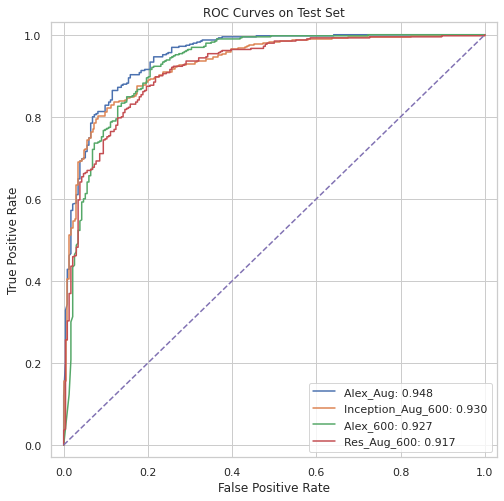

In [11]:
from sklearn.metrics import roc_curve, auc

fpr_dict = {}
tpr_dict = {}
auc_dict = {}

for name, preds in predProbDict.items():
    fpr, tpr, _ = roc_curve(trueList, preds)
    area = auc(fpr, tpr)
    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    auc_dict[name] = area

# Order the results in descending order
nameInOrder = pd.Series(auc_dict).sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots(figsize=(8, 8))

for name in nameInOrder:
    ax.plot(fpr_dict[name], tpr_dict[name], label=f'{name}: {auc_dict[name]:0.3f}')

ax.plot((0, 1), (0, 1), '--')
ax.legend()
ax.set_title('ROC Curves on Test Set')
ax.set_xlim([-0.03, 1.03])
ax.set_ylim([-0.03, 1.03])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.savefig(os.path.join(outputPath, 'plots/roc_curves.png'))
plt.show()

**End of notebook**